In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from plots.mpltoolkit import mpl_loc, named_colors, markers, fancy_legend, negative_log, load_style_sheet
import numpy as np
import vice
import sys
sys.path.append("..")
from src.utils import subsample_stellar_populations, get_velocity_profile, oh_to_12pluslog, boxcarsmoothtrend
from src.plots.utils import weighted_median, feuillet2019_data
load_style_sheet("papers")
print(sys.version_info)

/Users/jamesjohnson/Work/Research/lib/public-dev/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)


In [2]:
def mw_stellar_surface_density_profile(radius):
    sigma_0_thin = 1115e6
    sigma_0_thick = 300e6
    rs_thin = 2.5
    rs_thick = 2.0
    return sigma_0_thin * np.exp(-radius / rs_thin) + sigma_0_thick * np.exp(-radius / rs_thick)

def mw_gas_density_profile(radius, sigma_g_0 = 1.40e8, rs = 3.75):
    return sigma_g_0 * np.exp(-radius / rs)

In [3]:
outputs = [
    "../outputs/expifr/amd/base",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]
for out in outputs:
    extra = np.genfromtxt("%s_analogdata.out" % (out.name))
    out.stars["absz"] = [abs(_) for _ in extra[:,-1][:out.stars.size[0]]]

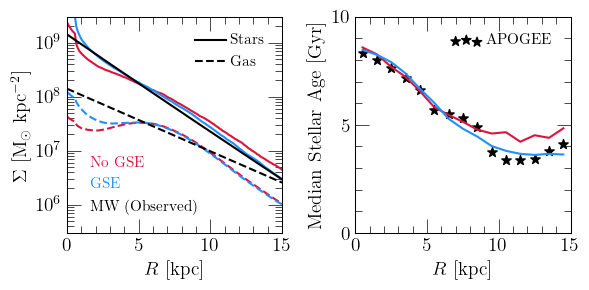

In [4]:
fig = plt.figure(figsize = (6, 3))
ax1 = fig.add_subplot(121)
ax1.set_xlabel(r"$R$ [kpc]")
ax1.set_ylabel(r"$\Sigma$ [M$_\odot$ kpc$^{-2}$]")
ax1.set_yscale("log")
ax1.set_xlim([0, 15])
ax1.set_ylim([3.0e5, 3.0e9])
ax1.set_xticks([0, 5, 10, 15])

ax2 = fig.add_subplot(122)
ax2.set_xlabel(r"$R$ [kpc]")
ax2.set_ylabel(r"Median Stellar Age [Gyr]")
ax2.set_xlim([0, 15])
ax2.set_ylim([0, 10])
ax2.set_xticks([0, 5, 10, 15])
ax2.set_yticks([0, 5, 10])

lines = []
lines.append(ax1.plot([100, 200], [100, 200], c = named_colors()["black"], linestyle = "-", label = "Stars")[0])
lines.append(ax1.plot([100, 200], [100, 200], c = named_colors()["black"], linestyle = "--", label = "Gas")[0])
kwargs = {
    "loc": mpl_loc("upper right"),
    "bbox_to_anchor": (0.98, 0.98),
    "fontsize": 11,
    "ncol": 1
}
leg = ax1.legend(**kwargs)
lines[0].remove()
lines[1].remove()
ax1.add_artist(leg)

def plot_surface_density_profile(ax, output, zone_width = 0.1, which = "stars", **kwargs):
    radii = []
    sigma = []
    for i in range(len(output.zones.keys())):
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        radii.append(zone_width * (i + 0.5))
        zone = output.zones["zone%d" % (i)]
        if which == "stars":
            key = "mstar"
        elif which == "gas":
            key = "mgas"
        else:
            raise ValueError("Bruh")
        sigma.append(zone.history[key][-1] / area)
    sigma = boxcarsmoothtrend(radii, sigma, window = 5)
    ax.plot(radii, sigma, **kwargs)

def plot_observed_ages(ax, filename = "./apogee-astronn-ageprofile.out", **kwargs):
    raw = np.genfromtxt(filename)
    radii = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
    age = raw[:, 3]
    ax.scatter(radii, age, **kwargs)

def plot_predicted_ages(ax, output, zone_width = 0.1, **kwargs):
    n_zones = len(output.zones.keys())
    # radii = [zone_width * (i + 0.5) for i in range(n_zones)]
    radii = list(range(16))
    ages = []
    for i in range(len(radii) - 1):
        # sys.stdout.write("\ri = %d
        inner = int(radii[i] / zone_width)
        outer = int(radii[i + 1] / zone_width) + 1
        stars = output.stars.filter(
            "zone_final", ">=", inner).filter(
            "zone_final", "<", outer).filter(
            "absz", "<=", 0.5).filter(
            "mass", ">", 1)
        ages.append(weighted_median(stars["age"], stars["mass"]))
    radii = [(a + b) / 2 for a, b in zip(radii[:-1], radii[1:])]
    ax.plot(radii, ages, **kwargs)

plot_surface_density_profile(ax1, outputs[0], c = named_colors()["crimson"], linestyle = "-", label = "No GSE")
plot_surface_density_profile(ax1, outputs[1], c = named_colors()["dodgerblue"], linestyle = "-", label = "GSE")

plot_surface_density_profile(ax1, outputs[0], which = "gas", c = named_colors()["crimson"], linestyle = "--")
plot_surface_density_profile(ax1, outputs[1], which = "gas", c = named_colors()["dodgerblue"], linestyle = "--")

xvals = np.linspace(*ax1.get_xlim(), 1000)
stars = [mw_stellar_surface_density_profile(r) for r in xvals]
gas = [mw_gas_density_profile(r) for r in xvals]
ax1.plot(xvals, stars, c = named_colors()["black"], linestyle = "-", label = "MW (Observed)")
ax1.plot(xvals, gas, c = named_colors()["black"], linestyle = "--")

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.02),
    "handlelength": 0,
    "fontsize": 11,
    "ncol": 1
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, ["crimson", "dodgerblue", "black"])

plot_observed_ages(ax2, c = named_colors()["black"], marker = markers()["star"], s = 50, label = "APOGEE")
plot_predicted_ages(ax2, outputs[0], c = named_colors()["crimson"])
plot_predicted_ages(ax2, outputs[1], c = named_colors()["dodgerblue"])

kwargs = {
    "loc": mpl_loc("upper right"),
    "bbox_to_anchor": (0.98, 0.98),
    "fontsize": 11
}
leg = ax2.legend(**kwargs)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./surface-density-profiles/surface-density-age-comparison.%s" % (ext), **kwargs)
plt.show()

In [3]:
outputs = [
    "../outputs/expifr/amd/base",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0p8",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin+0",
    "../outputs/expifr_gse/amd/tacc3p2/massratio3/expsigma/gsebetaphiin-0p8"
]
outputs = [vice.output(name) for name in outputs]

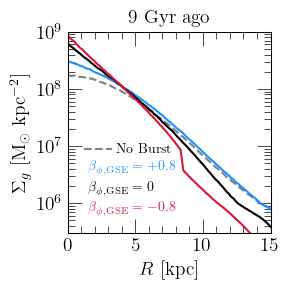

In [25]:
LOOKBACK = 9
COLORS = ["grey", "dodgerblue", "black", "crimson"]
LINESTYLES = ["--", "-", "-", "-"]
LABELS = [
    "No Burst",
    r"$\beta_{\phi,\text{GSE}} = +0.8$",
    r"$\beta_{\phi,\text{GSE}} = 0$",
    r"$\beta_{\phi,\text{GSE}} = -0.8$"
]

fig = plt.figure(figsize = (3, 3))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R$ [kpc]")
ax.set_ylabel(r"$\Sigma_g$ [M$_\odot$ kpc$^{-2}$]")
ax.set_title(r"$%g$ Gyr ago" % (LOOKBACK))
ax.set_yscale("log")
ax.set_xlim([0, 15])
ax.set_ylim([3.0e5, 1.0e9])

def plot_snapshot(ax, output, lookback, zone_width = 0.1, **kwargs):
    diff = [abs(_ - lookback) for _ in output.zones["zone0"].history["lookback"]]
    idx = diff.index(min(diff))
    radii = []
    sigma = []
    for i in range(len(output.zones.keys())):
        zone = output.zones["zone%d" % (i)]
        radii.append(zone_width * (i + 0.5))
        area = np.pi * zone_width**2 * ((i + 1)**2 - i**2)
        sigma.append(zone.history["mgas"][idx] / area)
    return ax.plot(radii, sigma, **kwargs)[0]

items = []
for i in range(len(outputs)):
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "linestyle": LINESTYLES[i],
        # "label": LABELS[i]
    }
    items.append(plot_snapshot(ax, outputs[i], LOOKBACK, **kwargs))

kwargs = {
    "loc": mpl_loc("lower left"),
    "bbox_to_anchor": (0.02, 0.32),
    "handlelength": 2,
    "fontsize": 10
}
leg = ax.legend([items[0]], [LABELS[0]], **kwargs)
ax.add_artist(leg)
kwargs["handlelength"] = 0
kwargs["bbox_to_anchor"] = (0.02, 0.02)
leg = ax.legend(items[1:], LABELS[1:], **kwargs)
fancy_legend(leg, COLORS[1:])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./surface-density-profiles/gas-profile-following-burst.%s" % (ext), **kwargs)
plt.show()